# Training the keypoint detector

## Solution description

I chose my model's architecture to be: a pretrained backbone (efficient net b1) and a few convolutional layers, with the size final output shape `[batch_size, 1, 1, n_of_keypoints * 3]`.
Every keypoint is represented by a three values: $x, y, vis$. 

### Two ways of handling visible vs invisible
Initially I trained training a model only with $x, y$, because these values encode information about $vis$. But it turned out, that because there is less visible objects than those not visible, my model stuck in suboptimal minima, predicting every point to have coordinates $(0, 0)$. That's why a added a seperate task of of predicting a visibility of a keypoint, apart from predictin its coordinates.

I could think of two solutions: 

* a model outputing one vector $(x_1, xy_1, vis_1, \dots , x_n, y_n, vis_n)$ 

* a model with two separate branches: one predicting the coordinates and one prediting the visibility.

In the latter scenario I could use an L2 loss on the coordinates branch and crossentropy loss on visibility probability branch. But because the the simpler, first solution gave me both precision and recall of predicting visiblity of a keypoint around 97\% i decided I didn't need this composite loss.

### Data augmentation

For the data augmentation I used geometric transformation: random rotation, random scale and random translation. I wrote this augmentation functions by my own. I decided not to use any other type of augmentation, e.g. changing color, contrast etc. I think that the dataset  is quite varied in terms of colors, some frames are darker, some are lighter, the grass has different color. 

### Metrics

As I suggested in my DataExploration notebook, to measure how well the model is dealing with insvisible keypoints I measured precision and recall of predicting that a keypoint is visible. Additionally, after each epoch I logged a graph into a Tensorboard, showing a confusion matrix calculated on a validation dataset.

I also logged predictions for a few first validation images, to visually monitor if the model is improving.

### Loss

I normalized $x$ and $y$ coordinates to be between $0$ and $1$, and so is $vis$. As I mentioned above, my model outputs a vector $(x_1, xy_1, vis_1, \dots , x_n, y_n, vis_n)$, where n is the number of keypoints. I used a simple $L2$ loss. 

# Imports

In [1]:
%load_ext autoreload
%autoreload 2

from datetime import datetime
from functools import partial
import os
from pathlib import Path

# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf

from pitch_geo.constants import DATA_FOLDER
from pitch_geo import data
from pitch_geo.models import models
import pitch_geo.models.augmentation as aug
# import pitch_geo.models.metrics
from pitch_geo.models.metrics import VisiblePrecision, VisibleRecall, XYMeanSquaredError
from pitch_geo.models.callbacks import LogConfusionMatrixCallback, LogPredictedImages
import pitch_geo.vis_utils as vis_utils

# Read the data frame

In [3]:
df = data.get_keypoints(dataset='train')

# Define hyperparameters

In [4]:
IMG_SIZE = 240
BATCH_SIZE = 32
EPOCHS = 100
NUM_KEYPOINTS = df['kid'].nunique()  # 34 pairs each having x and y coordinates

keypoint_ids = sorted(df['kid'].unique())
LABELS = {key: value for key, value in zip(range(len(keypoint_ids)), keypoint_ids)}

# Define augmentation

In [5]:
# I have already openCV instlalled. The official albumentations library advices to install it in that way
# !pip install -U albumentations --no-binary qudida,albumentations

In [6]:
# augmentations definitions are moved to package

# Prepare the data loaders

### Train / validation split

Split the train data into proportion: 85% train set and 15% validation set

In [7]:
images_paths = df['image_path'].unique()

train_paths, val_paths = train_test_split(images_paths, test_size=0.15, random_state=42, shuffle=True)

### Create the data loaders

In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = data.get_data_loader(paths=train_paths, df=df, image_size=IMG_SIZE, autotune=AUTOTUNE)
val_ds = data.get_data_loader(paths=val_paths, df=df, image_size=IMG_SIZE, autotune=AUTOTUNE)

2022-11-24 09:41:39.808618: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-24 09:41:39.843322: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-24 09:41:39.843754: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-24 09:41:39.845930: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [9]:
train_ds = (
    train_ds
    .shuffle(4000)
    .map(
        lambda image, keypoints: tf.numpy_function(func=aug.random_rotate, inp=[image, keypoints, 10, (0.5, 0.8)], Tout=[tf.float32, tf.float16]),
        num_parallel_calls=AUTOTUNE
    )
    .map(
        lambda image, keypoints: tf.numpy_function(func=aug.random_translate, inp=[image, keypoints, 0.3], Tout=[tf.float32, tf.float16]),
        num_parallel_calls=AUTOTUNE
    )
    .map(lambda image, keypoints: (image, tf.reshape(keypoints, [1, 1, NUM_KEYPOINTS * 3])), num_parallel_calls=AUTOTUNE)
    .map(
        partial(aug.set_shapes, img_shape=(IMG_SIZE, IMG_SIZE, 3), labels_shape=(1, 1, NUM_KEYPOINTS * 3)), 
        num_parallel_calls=AUTOTUNE
    )
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=AUTOTUNE)
)

In [10]:
val_ds = (
    val_ds
    .map(lambda image, keypoints: (image, tf.reshape(keypoints, [1, 1, NUM_KEYPOINTS * 3])), num_parallel_calls=AUTOTUNE)
    .map(
        partial(aug.set_shapes, img_shape=(IMG_SIZE, IMG_SIZE, 3), labels_shape=(1, 1, NUM_KEYPOINTS * 3)),
        num_parallel_calls=AUTOTUNE
    )
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=AUTOTUNE)
)

Visualize data from the data loader to see it everything works fine

In [11]:
# sample_batch = next(iter(train_ds))
# _ = vis_utils.show_image_with_annotations(sample_batch[0].numpy()[0,:] / 255., sample_batch[1].numpy()[0,:], dot_radius=3, vis=True)

In [12]:
print(f"Total batches in training set: {len(train_ds)}")
print(f"Total batches in validation set: {len(val_ds)}")

Total batches in training set: 102
Total batches in validation set: 18


# The model

## Get the model

The model is built with the `get_model` function. 

In [13]:
model = models.get_model(img_size=IMG_SIZE, num_keypoints=NUM_KEYPOINTS, dropout=0.1)

In [14]:
model.summary()

Model: "keypoint_detector"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 efficientnetb1 (Functional)  (None, 8, 8, 1280)       6575239   
                                                                 
 conv2d (Conv2D)             (None, 8, 8, 512)         5898752   
                                                                 
 conv2d_1 (Conv2D)           (None, 4, 4, 256)         1179904   
                                                                 
 conv2d_2 (Conv2D)           (None, 2, 2, 256)         262400    
                                                                 
 dropout (Dropout)           (None, 2, 2, 256)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 1, 1, 102)   

## Define callbacks

Callbacks used during the training loop.

In [15]:
model_base_path = Path('checkpoints')
checkpoint_template_name = 'saved_model.{epoch:03d}-{val_loss:.6f}'
training_timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
model_path = model_base_path / training_timestamp / checkpoint_template_name
log_dir = Path('logs') / training_timestamp

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=model_path,
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=True,
    mode="auto",
    save_freq="epoch",
)

tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    write_graph=False
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2,
    patience=5, 
    min_delta=0.0001,
    min_lr=0.000001,
    verbose=1
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=8,
    min_delta=0.00001,
    verbose=1,
)

log_cm = LogConfusionMatrixCallback(model, log_dir, val_ds)
cm_callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=log_cm)

log_predicted_images = LogPredictedImages(model, log_dir, val_ds, labels=LABELS)
log_images_callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=log_predicted_images, grid_size=4)

## Compile the model

## Train the model

In [16]:
%matplotlib

model.compile(
    loss='mean_squared_error',
    optimizer=tf.keras.optimizers.Adam(1e-3),
    metrics=[
        VisiblePrecision(),
        VisibleRecall(),
        XYMeanSquaredError(n_keypoints=NUM_KEYPOINTS)
    ],
    run_eagerly=False
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks = [
        model_checkpoint_callback,
        tensorboard_callback,
        reduce_lr,
        early_stopping,
        cm_callback,
        log_images_callback
    ],
)

Using matplotlib backend: <object object at 0x7fca280e48b0>
Epoch 1/100


2022-11-24 09:41:58.714574: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-11-24 09:42:01.448576: W tensorflow/core/common_runtime/bfc_allocator.cc:360] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smaller batch sizes to observe the performance impact. Set TF_ENABLE_GPU_GARBAGE_COLLECTION=false if you'd like to disable this feature.


102/102 [==============================] - 41s 265ms/step - loss: 0.0633 - visible_precision: 0.7647 - visible_recall: 0.5847 - xy_loss: 0.0632 - val_loss: 0.0247 - val_visible_precision: 0.9118 - val_visible_recall: 0.8951 - val_xy_loss: 0.0247 - lr: 0.0010
Epoch 2/100


2022-11-24 09:42:39.008949: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1841 of 4000


  1/102 [..............................] - ETA: 20:25 - loss: 0.0303 - visible_precision: 0.9364 - visible_recall: 0.8604 - xy_loss: 0.0303

2022-11-24 09:42:40.965693: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


102/102 [==============================] - 32s 201ms/step - loss: 0.0280 - visible_precision: 0.8806 - visible_recall: 0.8614 - xy_loss: 0.0280 - val_loss: 0.0186 - val_visible_precision: 0.9481 - val_visible_recall: 0.9111 - val_xy_loss: 0.0186 - lr: 0.0010
Epoch 3/100
102/102 [==============================] - 27s 223ms/step - loss: 0.0228 - visible_precision: 0.8999 - visible_recall: 0.8919 - xy_loss: 0.0228 - val_loss: 0.0162 - val_visible_precision: 0.9495 - val_visible_recall: 0.9195 - val_xy_loss: 0.0162 - lr: 0.0010
Epoch 4/100
102/102 [==============================] - 25s 198ms/step - loss: 0.0206 - visible_precision: 0.9076 - visible_recall: 0.9037 - xy_loss: 0.0206 - val_loss: 0.0154 - val_visible_precision: 0.9518 - val_visible_recall: 0.9293 - val_xy_loss: 0.0154 - lr: 0.0010
Epoch 5/100
102/102 [==============================] - 24s 198ms/step - loss: 0.0191 - visible_precision: 0.9145 - visible_recall: 0.9119 - xy_loss: 0.0191 - val_loss: 0.0136 - val_visible_precision:

/home/tensorflow-user/.local/lib/python3.8/site-packages/sklearn/metrics/_plot/confusion_matrix.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()
/workspace/pitch_geo/models/callbacks.py:97: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  figure, axes = plt.subplots(self.grid_size, self.grid_size, figsize=(10, 10))


102/102 [==============================] - 24s 191ms/step - loss: 0.0109 - visible_precision: 0.9498 - visible_recall: 0.9514 - xy_loss: 0.0109 - val_loss: 0.0103 - val_visible_precision: 0.9492 - val_visible_recall: 0.9679 - val_xy_loss: 0.0103 - lr: 0.0010
Epoch 21/100


2022-11-24 09:50:32.355589: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 877 of 4000


  1/102 [..............................] - ETA: 22:22 - loss: 0.0077 - visible_precision: 0.9799 - visible_recall: 0.9607 - xy_loss: 0.0077

2022-11-24 09:50:35.479224: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


1/1 [==============================] - 0s 37ms/step


/workspace/pitch_geo/models/callbacks.py:59: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  figure = plt.figure(figsize=(8, 8))


102/102 [==============================] - 33s 194ms/step - loss: 0.0116 - visible_precision: 0.9463 - visible_recall: 0.9471 - xy_loss: 0.0116 - val_loss: 0.0101 - val_visible_precision: 0.9587 - val_visible_recall: 0.9623 - val_xy_loss: 0.0101 - lr: 0.0010
Epoch 22/100


2022-11-24 09:51:05.255337: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 2012 of 4000


  1/102 [..............................] - ETA: 20:03 - loss: 0.0113 - visible_precision: 0.9519 - visible_recall: 0.9554 - xy_loss: 0.0113

2022-11-24 09:51:06.988725: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


102/102 [==============================] - 32s 194ms/step - loss: 0.0111 - visible_precision: 0.9487 - visible_recall: 0.9487 - xy_loss: 0.0111 - val_loss: 0.0108 - val_visible_precision: 0.9589 - val_visible_recall: 0.9480 - val_xy_loss: 0.0108 - lr: 0.0010
Epoch 23/100
102/102 [==============================] - 29s 197ms/step - loss: 0.0109 - visible_precision: 0.9495 - visible_recall: 0.9491 - xy_loss: 0.0109 - val_loss: 0.0095 - val_visible_precision: 0.9609 - val_visible_recall: 0.9642 - val_xy_loss: 0.0095 - lr: 0.0010
Epoch 24/100
102/102 [==============================] - ETA: 0s - loss: 0.0108 - visible_precision: 0.9503 - visible_recall: 0.9513 - xy_loss: 0.0107
Epoch 24: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
102/102 [==============================] - 24s 193ms/step - loss: 0.0108 - visible_precision: 0.9503 - visible_recall: 0.9513 - xy_loss: 0.0107 - val_loss: 0.0096 - val_visible_precision: 0.9681 - val_visible_recall: 0.9554 - val_xy_loss: 0.

2022-11-24 09:56:36.415399: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1064 of 4000


  1/102 [..............................] - ETA: 21:58 - loss: 0.0063 - visible_precision: 0.9837 - visible_recall: 0.9649 - xy_loss: 0.0063

2022-11-24 09:56:39.289225: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


102/102 [==============================] - 33s 202ms/step - loss: 0.0074 - visible_precision: 0.9660 - visible_recall: 0.9682 - xy_loss: 0.0074 - val_loss: 0.0077 - val_visible_precision: 0.9697 - val_visible_recall: 0.9685 - val_xy_loss: 0.0077 - lr: 2.0000e-04
Epoch 36/100
102/102 [==============================] - 25s 201ms/step - loss: 0.0071 - visible_precision: 0.9677 - visible_recall: 0.9676 - xy_loss: 0.0072 - val_loss: 0.0075 - val_visible_precision: 0.9678 - val_visible_recall: 0.9705 - val_xy_loss: 0.0075 - lr: 2.0000e-04
Epoch 37/100
102/102 [==============================] - 24s 195ms/step - loss: 0.0073 - visible_precision: 0.9651 - visible_recall: 0.9686 - xy_loss: 0.0073 - val_loss: 0.0076 - val_visible_precision: 0.9693 - val_visible_recall: 0.9676 - val_xy_loss: 0.0076 - lr: 2.0000e-04
Epoch 38/100
102/102 [==============================] - 25s 199ms/step - loss: 0.0073 - visible_precision: 0.9655 - visible_recall: 0.9667 - xy_loss: 0.0073 - val_loss: 0.0078 - val_vis

2022-11-24 09:58:49.254517: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1763 of 4000


  1/102 [..............................] - ETA: 20:38 - loss: 0.0084 - visible_precision: 0.9568 - visible_recall: 0.9744 - xy_loss: 0.0084

2022-11-24 09:58:51.329467: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


102/102 [==============================] - 32s 193ms/step - loss: 0.0071 - visible_precision: 0.9668 - visible_recall: 0.9698 - xy_loss: 0.0071 - val_loss: 0.0076 - val_visible_precision: 0.9674 - val_visible_recall: 0.9681 - val_xy_loss: 0.0076 - lr: 2.0000e-04
Epoch 41/100
102/102 [==============================] - ETA: 0s - loss: 0.0070 - visible_precision: 0.9675 - visible_recall: 0.9694 - xy_loss: 0.0070
Epoch 41: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
102/102 [==============================] - 24s 196ms/step - loss: 0.0070 - visible_precision: 0.9675 - visible_recall: 0.9694 - xy_loss: 0.0070 - val_loss: 0.0077 - val_visible_precision: 0.9698 - val_visible_recall: 0.9654 - val_xy_loss: 0.0077 - lr: 2.0000e-04
Epoch 42/100
102/102 [==============================] - 24s 196ms/step - loss: 0.0069 - visible_precision: 0.9676 - visible_recall: 0.9703 - xy_loss: 0.0069 - val_loss: 0.0075 - val_visible_precision: 0.9704 - val_visible_recall: 0.9687 - val_xy_

2022-11-24 10:02:35.766239: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1068 of 4000


  1/102 [..............................] - ETA: 22:02 - loss: 0.0068 - visible_precision: 0.9686 - visible_recall: 0.9858 - xy_loss: 0.0068

2022-11-24 10:02:38.695416: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


102/102 [==============================] - 33s 196ms/step - loss: 0.0068 - visible_precision: 0.9693 - visible_recall: 0.9705 - xy_loss: 0.0068 - val_loss: 0.0073 - val_visible_precision: 0.9701 - val_visible_recall: 0.9697 - val_xy_loss: 0.0073 - lr: 4.0000e-05
Epoch 50/100
102/102 [==============================] - 24s 197ms/step - loss: 0.0067 - visible_precision: 0.9680 - visible_recall: 0.9713 - xy_loss: 0.0067 - val_loss: 0.0074 - val_visible_precision: 0.9714 - val_visible_recall: 0.9676 - val_xy_loss: 0.0074 - lr: 4.0000e-05
Epoch 51/100


2022-11-24 10:03:32.966593: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 877 of 4000


  1/102 [..............................] - ETA: 22:15 - loss: 0.0117 - visible_precision: 0.9390 - visible_recall: 0.9390 - xy_loss: 0.0117

2022-11-24 10:03:36.015641: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


102/102 [==============================] - 33s 195ms/step - loss: 0.0065 - visible_precision: 0.9709 - visible_recall: 0.9718 - xy_loss: 0.0065 - val_loss: 0.0073 - val_visible_precision: 0.9709 - val_visible_recall: 0.9715 - val_xy_loss: 0.0073 - lr: 4.0000e-05
Epoch 52/100
102/102 [==============================] - ETA: 0s - loss: 0.0063 - visible_precision: 0.9697 - visible_recall: 0.9736 - xy_loss: 0.0063
Epoch 52: ReduceLROnPlateau reducing learning rate to 8.000000525498762e-06.
102/102 [==============================] - 24s 198ms/step - loss: 0.0063 - visible_precision: 0.9697 - visible_recall: 0.9736 - xy_loss: 0.0063 - val_loss: 0.0073 - val_visible_precision: 0.9708 - val_visible_recall: 0.9695 - val_xy_loss: 0.0073 - lr: 4.0000e-05
Epoch 53/100
102/102 [==============================] - 24s 196ms/step - loss: 0.0065 - visible_precision: 0.9701 - visible_recall: 0.9709 - xy_loss: 0.0065 - val_loss: 0.0073 - val_visible_precision: 0.9707 - val_visible_recall: 0.9703 - val_xy_l

In [17]:
model.save(model_path.parent / 'saved_model')

INFO:tensorflow:Assets written to: checkpoints/20221124_094146/saved_model/assets


INFO:tensorflow:Assets written to: checkpoints/20221124_094146/saved_model/assets


In [18]:
def get_callbacks(model):
    model_base_path = Path('checkpoints')
    checkpoint_template_name = 'weights.{epoch:03d}-{val_loss:.5f}'
    training_timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    model_path = model_base_path / training_timestamp / checkpoint_template_name
    log_dir = Path('logs') / training_timestamp
    
    print(f'INFO: logdir = "{log_dir}"')

    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=model_path,
        monitor="val_loss",
        save_best_only=False,
        save_weights_only=True,
        mode="auto",
        save_freq="epoch",
    )

    tensorboard_callback = tf.keras.callbacks.TensorBoard(
        log_dir=log_dir,
        write_graph=False
    )

    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', 
        factor=0.2,
        patience=5, 
        min_delta=0.0001,
        min_lr=0.000001,
        verbose=1
    )

    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=8,
        min_delta=0.0001,
        verbose=1,
    )

    log_cm = LogConfusionMatrixCallback(model, log_dir, val_ds)
    cm_callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=log_cm)
    
    return model_checkpoint_callback, tensorboard_callback, reduce_lr, early_stopping, cm_callback

In [19]:
import itertools


def grid_search():
    learning_rates = [1e-5, 1e-4, 1e-3, 1e-2]
    dropouts = [None, 0.05, 0.1, 0.2, 0.5, 0.9]
    
    for lr, dropout in itertools.product(learning_rates, dropouts):
        model = models.get_model(img_size=IMG_SIZE, num_keypoints=NUM_KEYPOINTS, dropout=dropout)

        model.compile(
            loss='mean_squared_error',
            optimizer=tf.keras.optimizers.Adam(lr),
            metrics=[
                VisiblePrecision(),
                VisibleRecall(),
                XYMeanSquaredError(n_keypoints=NUM_KEYPOINTS)
            ],
        )
        callbacks = get_callbacks(model)
        print(f'INFO: using {lr=} {dropout=}')
        history = model.fit(
            train_ds,
            validation_data=val_ds,
            epochs=EPOCHS,
            callbacks = callbacks,
            verbose=2
        )

In [20]:
%matplotlib
# grid_search()

Using matplotlib backend: agg


### Plots

In [ ]:
model = tf.keras.models.load('checkpoints/20221124_094146/saved_model

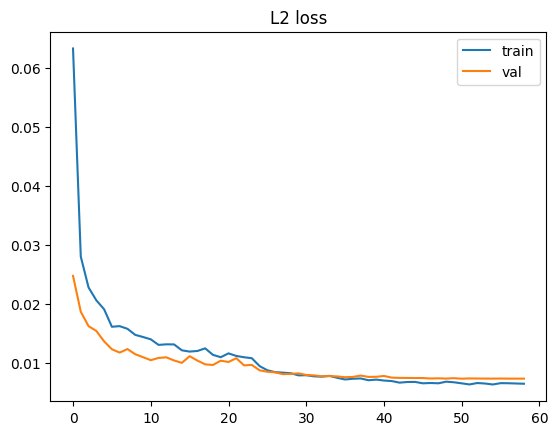

In [22]:
%matplotlib inline
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('L2 loss')
plt.legend()
plt.show()

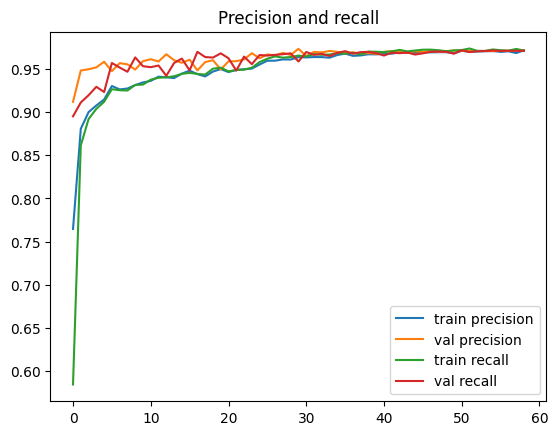

In [24]:
%matplotlib inline
plt.plot(history.history['visible_precision'], label='train precision')
plt.plot(history.history['val_visible_precision'], label='val precision')
plt.plot(history.history['visible_recall'], label='train recall')
plt.plot(history.history['val_visible_recall'], label='val recall')
plt.title('Precision and recall')
plt.legend()
plt.show()

In [31]:
# model = get_model()

sample_val_images, sample_val_keypoints = next(iter(val_ds))
sample_val_images = sample_val_images
sample_val_keypoints = sample_val_keypoints.numpy()  # .reshape(-1, 38, 2)

predictions = model.predict(sample_val_images)    # .reshape(-1, 38, 2)

1/1 [==============================] - 0s 113ms/step


In [32]:
# Ground-truth
vis_utils.show_image_with_annotations(sample_val_images.numpy()[0,:] / 255., sample_val_keypoints[0,:], dot_radius=3, vis=True)

TypeError: show_image_with_annotations() missing 1 required positional argument: 'labels'

In [ ]:
# Predictions
vis_utils.show_image_with_annotations(sample_val_images.numpy()[1,:] / 255., predictions[1], dot_radius=3, normalized=True, vis=True)

In [ ]:
plt.hist(predictions[0].reshape(38, 3)[:, 2])

In [ ]:
# model.evaluate(x=sample_val_images[:3], y=sample_val_keypoints[:3])

# Accuracy of predicting visible vs invisible

In [ ]:
from pitch_geo.models.metrics import get_visible_from_array

In [ ]:
ys = []
for x, y in val_ds:
    ys.append(get_visible_from_array(y.numpy(), 0.5))

In [ ]:
import numpy as np

In [ ]:
ys = np.concatenate(ys)

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
vis = df[df['image_path'].isin(test_paths)]['vis']
print(f"% of invisible keypoints in validation set: {(vis == False).mean():0.2%}")

In [ ]:
y_hat = model.predict(val_ds)

In [ ]:
vis_hat = get_visible_from_array(y_hat, 0.5)

In [ ]:
vis_hat = y.reshape(574, NUM_KEYPOINTS, 3)[:, :, 2] > 0.1
(vis_hat.reshape(-1) == vis).mean()

In [ ]:
%matplotlib
log_cm = LogConfusionMatrixCallback(model, Path('tmp'), val_ds.take(1))
img = log_cm.calculate_cm()

In [ ]:
# %matplotlib inline
plt.imshow(img.numpy()[0, :, :, :])

In [ ]:
TP = cm[1, 1]
FP = cm[0, 1]
FN = cm[1, 0]

precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1_score = 2 * precision * recall / (precision + recall)

In [ ]:
print(f'classifying points as invisible:')
print(f'precision:\t{precision:.4f}')
print(f'recall:\t\t{recall:.4f}')
print(f'f1 score:\t{f1_score:.4f}')

# Analysis of losses

## Histogram of losses

Are there any special cases with big loss, or is the loss evenly spread across all the samples?

In [ ]:
y_true.shape

In [ ]:
model.evaluate(val_ds)

In [ ]:
y

In [ ]:
mse = tf.keras.losses.MeanSquaredError()

In [ ]:
# val_df = df[df['image_path'].isin(test_paths)]
# y_true = val_df[['x', 'y', 'vis']].values.astype(np.float32)

In [ ]:
y_true.shape

In [ ]:
y.shape

In [ ]:
y.reshape(-1).shape

In [ ]:
mse(y_true, y.reshape(-1, 3))

In [ ]:
loss = []
for i in range(y.shape[0]):
    loss.append(mse(y_true[i], y_hat[i]))

In [ ]:
plt.hist(loss)
plt.show()

In [ ]:
y_true.shape

In [ ]:
y.shape

In [ ]:
mse(y_true, y_hat)

In [ ]:
np.mean(loss)

# Performance of a naive model

Is the loss 0.0458 big or small? To understand a bit the magnitude of a loss, let's consider a loss of a model predicting every point to lie in a center of a frame. Or in $(0, 0)$ point.

In [ ]:
mse = tf.keras.losses.MeanSquaredError()

In [ ]:
y_true = []
for _, y in val_ds:
    y_true.append(y.numpy())
    
y_true = np.vstack(y_true)

In [ ]:
y_true.shape

In [ ]:
y_naive = np.ones_like(y_true) * 0.5
print(mse(y_true, y_naive))

In [ ]:
y_naive = np.zeros_like(y_true)
print(mse(y_true, y_naive))

It looks as if the most reasonable thing the model can do is to always predict (0, 0)!

I can fight it either with using augmentation that would cuase the upperleft corner to move, or with a different loss function, that would more penalize predict (0, 0) (not visible) if the ground truth keypoint is actually visible. But the first option is easier.